**Proyek Pertama : Membuat Model NLP dengan TensorFlow**

Hierarchical Taxonomy of Wikipedia article classes
- Proyek ini mengklasifikasikan teks ke dalam 9 kelas.
- Dataset yang digunakan dalam model ini diambil dari ==>[DBPedia Classes](https://www.kaggle.com/danofer/dbpedia-classes)
- Proyek ini dikerjakan sebagai syarat menyelesaikan modul Natural Language Processing (NLP) dengan TensorFlow dalam kelas [Belajar Pengembangan Machine Learning](https://www.dicoding.com/academies/185) di [dicoding](https://www.dicoding.com/)

Nama : Toni Andreas Susanto

Asal : Kota Samarinda, Provinsi Kalimantan Timur

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google'

In [2]:
!unzip /content/gdrive/MyDrive/dataset/DBP_wiki_data.csv.zip > /dev/null

In [3]:
# Menyiapkan dataset
import pandas as pd
df = pd.read_csv('DBP_wiki_data.csv')
df.head()

,text,l1,l2,l3,wiki_name,word_count
0,The 1994 Mindoro earthquake occurred on Novemb...,Event,NaturalEvent,Earthquake,1994_Mindoro_earthquake,59
1,The 1917 Bali earthquake occurred at 06:50 loc...,Event,NaturalEvent,Earthquake,1917_Bali_earthquake,68
2,The 1941 Colima earthquake occurred on April 1...,Event,NaturalEvent,Earthquake,1941_Colima_earthquake,194
3,The 1983 Coalinga earthquake occurred on May 2...,Event,NaturalEvent,Earthquake,1983_Coalinga_earthquake,98
4,The 2013 Bushehr earthquake occurred with a mo...,Event,NaturalEvent,Earthquake,2013_Bushehr_earthquake,61


In [4]:
# Melihat informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342781 entries, 0 to 342780
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        342781 non-null  object
 1   l1          342781 non-null  object
 2   l2          342781 non-null  object
 3   l3          342781 non-null  object
 4   wiki_name   342781 non-null  object
 5   word_count  342781 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 15.7+ MB


In [5]:
# Menghapus kolom yang tidak diperlukan
df = df.drop(columns=['wiki_name','word_count','l2','l3'])
df # Tampilkan!

,text,l1
0,The 1994 Mindoro earthquake occurred on Novemb...,Event
1,The 1917 Bali earthquake occurred at 06:50 loc...,Event
2,The 1941 Colima earthquake occurred on April 1...,Event
3,The 1983 Coalinga earthquake occurred on May 2...,Event
4,The 2013 Bushehr earthquake occurred with a mo...,Event
...,...,...
342776,WCSH is the NBC-affiliated television station ...,Agent
342777,Al Jazeera America (AJAM) was an American basi...,Agent
342778,"CJOH-DT, VHF channel 13, is a CTV owned-and-op...",Agent
342779,NTTV (North Texas Television) is a student tel...,Agent


In [6]:
# Melakukan one-hot-encoding
category = pd.get_dummies(df.l1)

# gabungkan hasil one-hot-encoding
df_new = pd.concat([df, category], axis=1)

# hapus kolom l1 karena hasil one-hot-encoding telah ada sebagai penggantinya.
df_new = df_new.drop(columns='l1')
df_new # Tampilkan!

,text,Agent,Device,Event,Place,Species,SportsSeason,TopicalConcept,UnitOfWork,Work
0,The 1994 Mindoro earthquake occurred on Novemb...,0,0,1,0,0,0,0,0,0
1,The 1917 Bali earthquake occurred at 06:50 loc...,0,0,1,0,0,0,0,0,0
2,The 1941 Colima earthquake occurred on April 1...,0,0,1,0,0,0,0,0,0
3,The 1983 Coalinga earthquake occurred on May 2...,0,0,1,0,0,0,0,0,0
4,The 2013 Bushehr earthquake occurred with a mo...,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
342776,WCSH is the NBC-affiliated television station ...,1,0,0,0,0,0,0,0,0
342777,Al Jazeera America (AJAM) was an American basi...,1,0,0,0,0,0,0,0,0
342778,"CJOH-DT, VHF channel 13, is a CTV owned-and-op...",1,0,0,0,0,0,0,0,0
342779,NTTV (North Texas Television) is a student tel...,1,0,0,0,0,0,0,0,0


In [7]:
# Mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values.
text = df_new['text'].values
kelas = df_new[['Agent', 'Device', 'Event', 'Place', 'Species','SportsSeason','TopicalConcept','UnitOfWork','Work']].values

In [8]:
# Membagi data untuk training dan testing.
from sklearn.model_selection import train_test_split
text_train, text_test, kelas_train, kelas_test = train_test_split(text, kelas, test_size=0.2)

In [9]:
# Melakukan tokenisasi & mengonversi setiap sampel menjadi sequence.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Proses tokenisasi
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(text_train)
tokenizer.fit_on_texts(text_test)

# Proses sequence
sekuens_train = tokenizer.texts_to_sequences(text_train)
sekuens_test = tokenizer.texts_to_sequences(text_test)

padded_train = pad_sequences(sekuens_train)
padded_test = pad_sequences(sekuens_test)

In [10]:
# Implementasi callbacks
import tensorflow as tf
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=1.5e-5
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=12,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

In [11]:
''' 
Membangun arsitektur dengan model sequential. Selain itu, menggunakan Embedding,
LSTM, Droupout, dan Dense serta menggunakan aktivasi softmax.
'''
import tensorflow as tf
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=20000, output_dim=64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1280000   
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 9)                 585       
                                                                 
Total params: 1,313,609
Trainable params: 1,313,609
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Memlih optimizer, loss dan metrics.
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Melatih model.
history = model.fit(
    padded_train, 
    kelas_train,
    epochs=2,
    batch_size=128,
    callbacks = [reduce_lr, early_stop],
    verbose=1,
    validation_data=(padded_test, kelas_test)
)

Epoch 1/2
2143/2143 [==============================] - 2231s 1s/step - loss: 0.2752 - accuracy: 0.9271 - val_loss: 0.1822 - val_accuracy: 0.9511 - lr: 0.0010
Epoch 2/2
2143/2143 [==============================] - 2233s 1s/step - loss: 0.1830 - accuracy: 0.9537 - val_loss: 0.1312 - val_accuracy: 0.9712 - lr: 0.0010


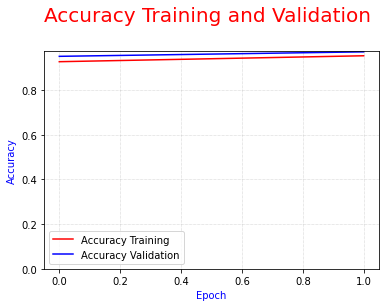

<Figure size 432x288 with 0 Axes>

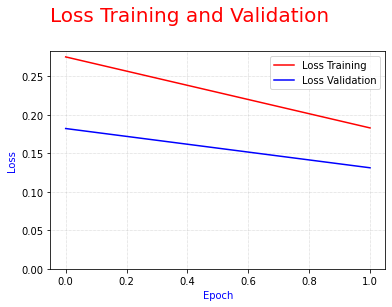

<Figure size 432x288 with 0 Axes>

In [17]:
# ========================== Membuat plot loss dan akurasi pada saat training dan validation. =======================================
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

# Plot akurasi training dan validasi
plt.plot(epochs, accuracy, 'r', label='Accuracy Training')
plt.plot(epochs, val_accuracy, 'b', label='Accuracy Validation')
plt.title('Accuracy Training and Validation', loc='left', pad=30, fontsize=20, color='red')
plt.ylabel('Accuracy', color='blue')
plt.xlabel('Epoch', color='blue')
plt.legend(loc=0)
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
plt.ylim(ymin=0)
plt.figure()
plt.show()

# Plot loss training dan validasi
plt.plot(epochs, loss, 'r', label='Loss Training')
plt.plot(epochs, val_loss, 'b', label='Loss Validation')
plt.title('Loss Training and Validation', loc='left', pad=30, fontsize=20, color='red')
plt.ylabel('Loss', color='blue')
plt.xlabel('Epoch', color='blue')
plt.legend(loc=0)
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
plt.ylim(ymin=0)
plt.figure()
plt.show()